In [1]:
from readfiles import *
import sys
import numpy.linalg as LA
import copy
from unit import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Writing main Hamiltonian

In [2]:
# Now defining Units and conversion factors. 
h = 6.62607015e-34 # planck's constant in joules second
c = 2.99792458e10 # speed of light in cm per second
e = 1.60217663e-19 # charge of electron in coulombs
hbar = 0.658211951 # in eV-fs or meV-ps or ueV-ns
cm2ev = c*h/e  # conversion factor from 1/cm to eV
cm2mev = cm2ev * 1.e3  # conversion from 1/cm to meV
ev2au = e/4.3597447222071e-18  # converison from eV to atomic mass units
cm2au = cm2ev * ev2au  # conversion from 1/cm to atomic mass units

kB = 8.617333262e-2 # meV/K, Boltzmann constant

In [3]:
free_e_gyro = 28024.9514242E6 # Hz/T gyromagnetic ratio of an electron.
hz2meV = 4.1357E-12 # 1Hz = 4.1357E-15 eV = 4.1357E-12 meV
free_e_gfactor = 2.00231930437378 # free electron g factor 2.00231930437378
alpha = (free_e_gyro*hz2meV)/free_e_gfactor # gyromagnetic ratio/gfactor in meV per tesla
print("alpha in units of meV per tesla = "+str(alpha))
print("hbar is contained in the definition of alpha")

alpha in units of meV per tesla = 0.057884270182028845
hbar is contained in the definition of alpha


In [4]:
eS = jmat(1/2)
eS

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.  0.5]
  [0.5 0. ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j  0.-0.5j]
  [0.+0.5j 0.+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0. ]
  [ 0.  -0.5]])

In [5]:
sigma_vec = [sigmax(), sigmay(), sigmaz()]
sigma_vec

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 1.]
  [1. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]]]

In [6]:

# NOTE: using the pauli vector instead of spin half operators. Defining a single spin half operators
#eS = jmat(1/2) # list of electronic spin operators [Sx, Sy, Sz] 
# NOTE: In qutip, the eigensolver transforms the Matrix with eigen values in ascending order.

# Loading the gtensor for the basic Hamiltonian.
fname = 'data files/gtensor.dat' # loading the gtensor, hyperfine tensor, and ztensor. 
gtensor, hfc, zfs = read_g(fname)

# Defining External magnetic field vector
Bfield = 200 # Tesla
print("applied magnetic field is ", Bfield, " Tesla")

Bvector = np.zeros(3)
Bvector[0] = 0
Bvector[1] = 0
Bvector[2] = Bfield


# Defining spin Hamiltonian
H = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H is None:
            H = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j]# instead of spin 1/2 matrices 

print('Spin zeeman hamiltonian')
#H.tidyup()
H

applied magnetic field is  200  Tesla
Spin zeeman hamiltonian


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 11.52007767+0.j           0.01276522+0.00512334j]
 [  0.01276522-0.00512334j -11.52007767+0.j        ]]

In [7]:
energies, estates  = (-H).eigenstates() # the eigenstates are in acending order, the -ve reintroduces the decending order
energies, estates

(array([-11.52008588,  11.52008588]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-9.99999822e-01+0.j        ]
         [-5.54041893e-04+0.00022237j]]                              ,
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-5.96999835e-04+0.j        ]
         [ 9.28043463e-01-0.37247144j]]                              ],
       dtype=object))

In [8]:
H = H.transform(estates)
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 11.52008588   0.        ]
 [  0.         -11.52008588]]

### At this point we should tranform the coupings to new eigen basis as well. but since the new basis are very close to the prevous one, I think we can ommitt this step with negligible error

# Loading and visualizing frequencies and gtensor derivative i.e. dgx

In [9]:
# Loading the couplings and frequencies
freq, dgx = get_phonon('data files/spin_phonon.dat')
freq = freq*cm2mev
print("the intra vibrations of a single molecule are the harmonic frequencies here in meV")

number of vibs= 190
the intra vibrations of a single molecule are the harmonic frequencies here in meV


In [10]:
dgx[0]

array([[-2.4308993e-03, -3.6944117e-03,  1.8978486e-03],
       [-2.8236532e-03,  1.5009815e-03,  8.7550132e-05],
       [ 1.0964913e-03,  5.0411135e-04,  3.4037204e-04]])

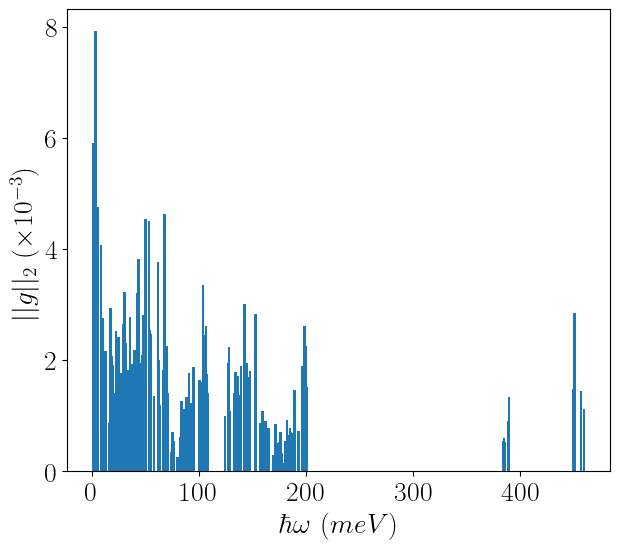

In [11]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq, np.array(zeeman_l2_norm)*1e3, width = 2.5)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$\hbar \omega \ (meV)$ ')
plt.ylabel(r'$||g||_2 \ (\times 10^{-3})$')
plt.show()

### Converting derivatives of gtensor into couplings $\tilde c$ with Pauli matrices

$$
gcoupS= \tilde c_{\alpha k} = \alpha \frac{\partial g_{\alpha z}}{\partial q_k} B_z (1/2)
$$

Note: this last 1/2 is comming from converting spin half opertors (S) to pauli matrices

In [12]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# NOTE: this coupling also has the harmonic bath displacement operator contained in it. therefore, it has units of meV.
print('First 5 new couplings \n', gcoupS[:5])
print('these couplings are for the Pauli X, Y, Z operators.')

First 5 new couplings 
 [[ 0.01098556  0.00050678  0.00197022]
 [-0.00582464  0.0016868  -0.00963291]
 [ 0.00125344 -0.0059917  -0.00460528]
 [-0.00085962 -0.00481263 -0.00841203]
 [-0.00435588  0.00196967 -0.00646957]]
these couplings are for the Pauli X, Y, Z operators.


# Understanding of the couplings.

$$
H_{int} = \sum_i A_i \otimes C_i = \sum_i \sigma_i C_i
$$

where $A_i$ are system operators i.e. $\sigma_i$ Pauli matrices, and $C_i$ are linear sum of phonon displacement operators. 
i.e. 
$$
C_i = \sum_j c^{(i)}_j u_j
$$

In the case of Zeeman Hamiltonian, the spin-phonon interaction is consequence of variation in g-tensor as a result of atomic displacements due to molecular vibrations. Therefore, 
$$
H_{int} = \sum_i \sigma_i [\frac{\alpha}{2}\sum_{jk} \frac{\partial g_{ik}}{\partial u_j} B_k u_j] = \sum_i \sigma_i (\sum_{j}c^i_j u_j) =\sum_i \sigma_i C_i
$$
where $B_k$ are elements of magnetic field vector, $g^j$ is the g-tensor, $\alpha$ contains gyromagnetic ratio and acts like a conversion factor for the entire term to energy (meV/T). Finally 
$$
c^i_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j} B_k 
$$

### NOW instead of $\frac{\partial g_{ik}}{\partial u_j}$, we have $\frac{\partial g_{ik}}{\partial u_j}\Delta u_j = dgx$

so one way forward is to assume: 
$$
c^i_j u_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j}\Delta u_j B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = gcoup \frac{u_j}{\Delta u_j}
$$

Now this means that there is this puzzle of what the value for $\Delta u_j$ happens to be; can I take it as some normalization factor?

### Defining spectral densities

In [13]:
def shape_normal(w, w0, sigma):
    '''
    this function returns a Gaussian/Normal distribution centered at w0 with std sigma
    '''
    return np.exp(-0.5*((w-w0)/sigma)**2)/(sigma*np.sqrt(2*np.pi))


def lorentzian(w, w0, sigma):
    '''
    this function returns a lorentzian profile centered at 'w0' with thickness 'sigma'
    NOTE: sigma is related to the lifetime of the mode by tau = hbar/sigma
    '''
    return  sigma/(np.pi*(sigma**2 + (w-w0)**2))

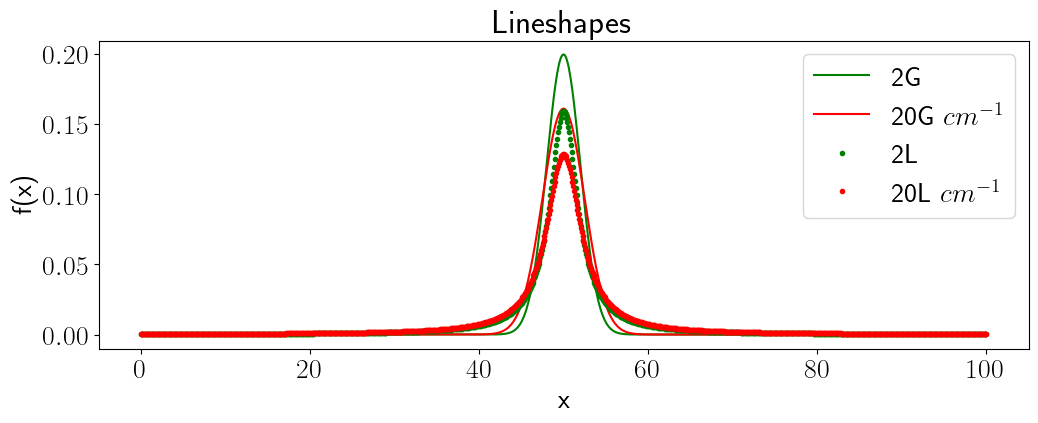

In [14]:
# lets test it out. 
x = np.linspace(0, 100, 1000)
y1 = [shape_normal(w, w0=50, sigma=1) for w in x]
y2 = [shape_normal(w, w0=50, sigma=2) for w in x]
y20cm = [shape_normal(w, w0=50, sigma=20*cm2mev) for w in x]

y1l = [lorentzian(w, w0=50, sigma=1) for w in x]
y2l = [lorentzian(w, w0=50, sigma=2) for w in x]
y20cml = [lorentzian(w, w0=50, sigma=20*cm2mev) for w in x]



plt.figure(figsize=(12,4))
#plt.plot(x,y1, 'b')
plt.plot(x,y2, 'g')
plt.plot(x,y20cm, 'r')
#plt.plot(x,y1l, 'b.-')
plt.plot(x,y2l,'g.')
plt.plot(x,y20cml,'r.')
plt.title("Lineshapes")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(['2G','20G $cm^{-1}$','2L','20L $cm^{-1}$'])
plt.show()

In [15]:
def spectral_density_quantum(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    n = n_thermal = pop of harmonic oscillator mode with frequency ‘w’, at the temperature described by ‘w_th’ where 𝜔_th = 𝑘𝐵 𝑇/ℏ
    NOTE: freqs and couplings must be passed in energy units i.e. meV. 
    units of S(w) are [(meV)^2 s]

    Note: It requires cij tilde converts it into cij by division with sqrt(hbar/2wj) and then computes the spectral density
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*T/hbar # temperature defined as frequency
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy / length
        nj = n_thermal(wj,w_th)
        #sigma = 0.1*wj
        if shape=='G':
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*shape_normal(w, wj, sigma) + nj*shape_normal(w, -wj, sigma) )
        else:
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*lorentzian(w, wj, sigma) + nj*lorentzian(w, -wj, sigma) )
    return S

def spectral_density_classical(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    Units of S(w) are energy (meV) if freqs and couplings are in frequency units.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy/length
        if shape=='G':
            S += np.pi*kB*T*(cj**2/wj**2)*(shape_normal(w, wj, sigma) + shape_normal(w, -wj, sigma))
        else:
            S += np.pi*kB*T*(cj**2/wj**2)*(lorentzian(w, wj, sigma) + lorentzian(w, -wj, sigma))
    return S

NOTE: The quantum spectral density follows the equation 
Starting from the time domain description: 
$$
S(t) = \sum_j \frac{\hbar c_j^2}{2\omega_j} [(n_j +1)e^{-i\omega_j t} + n_j e^{i\omega_j t}]
$$
we transform to the fourier domain using definition
$$
2\pi \delta(\omega\pm \omega_j) = \int_{-\infty}^{-\infty} e^{ i (\omega \pm \omega_j) t} dt
$$
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) \delta(\omega - \omega_j)+n_j\delta(\omega+\omega_j)  ]
$$
where $n(\omega_j)$ and the delta shapes will be replaced by the Gaussian
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) G(\omega_j, \sigma)+n_jG(-\omega_j, \sigma)  ]
$$

in the high temperature limit $n_j = \frac{k_B T}{\hbar \omega_j} >> 1$. This leads to 
$$
S(\omega) = \pi k_B T \sum_j \frac{c_j^2}{\omega_j^2} [G(\omega_j, \sigma) + G(-\omega_j, \sigma)  ]
$$

which is the same as classical spectral density. NOTE: time domain classical funciton is 
$$
S(t) = k_B T \sum_j \frac{c_j^2}{\omega_j^2} cos(\omega_j t)
$$



### Implementation detail. 
From the dimensional analysis fo the generic interaciton Hamiltonian
$$
H_{int} = \sum_{ij} c_{ij} (\sigma_i \otimes \hat{X}_j)
$$
$c$'s must be in $energy/[X]$ untis. Using definition $X_j = \sqrt{\frac{\hbar}{2\omega_j}}(a^\dagger_j + a_j)$

our couplings will have to be re formed as $c_{new} = c \times (\frac{\hbar}{2\omega_j})^{-1/2}$

new units of couplings are $[c_{new}] = \frac{\sqrt{eng}}{s}$. 

Consequently, $[S(\omega)] = eng^2 s$ and $ [S(\omega)/\hbar^2] = 1/s$

/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:41: RuntimeWarning: overflow encountered in exp
  if (w_th > 0) and np.exp(w / w_th) != 1.0:
/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:42: RuntimeWarning: overflow encountered in exp
  return 1.0 / (np.exp(w / w_th) - 1.0)


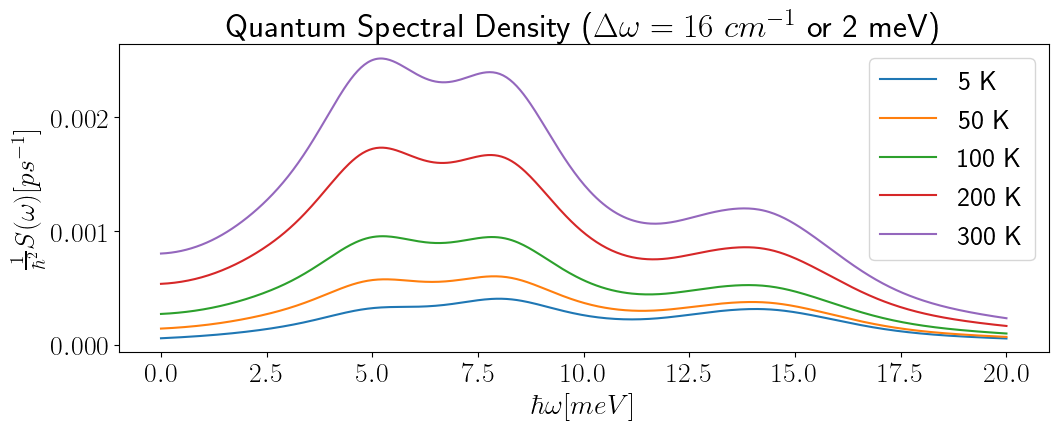

In [16]:
x = np.linspace(0, 20, 500)
y5q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]
plt.figure(figsize=(12,4))
plt.plot(x,y5q)
plt.plot(x,y50q)
plt.plot(x,y100q)
plt.plot(x,y200q)
plt.plot(x,y300q)
plt.title(r"Quantum Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

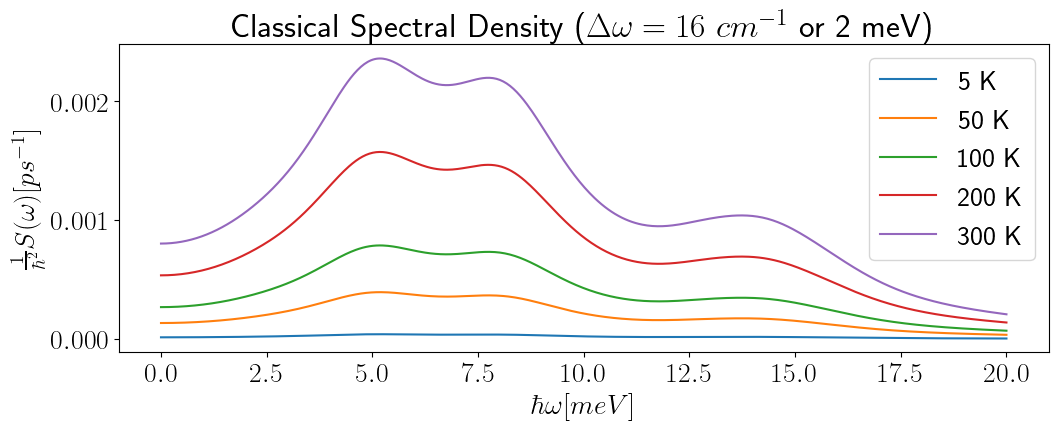

In [17]:
x = np.linspace(0, 20, 500)
y5c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]

plt.figure(figsize=(12,4))
plt.plot(x,y5c)
plt.plot(x,y50c)
plt.plot(x,y100c)
plt.plot(x,y200c)
plt.plot(x,y300c)
plt.title(r"Classical Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

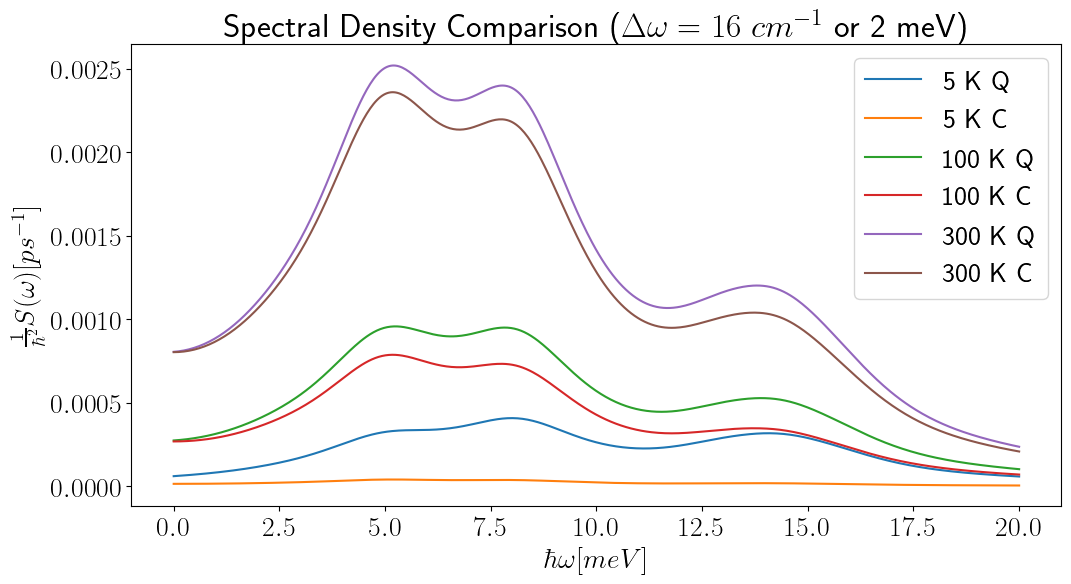

In [18]:
plt.figure(figsize=(12,6))
plt.plot(x,y5q)
plt.plot(x,y5c)
plt.plot(x,y100q)
plt.plot(x,y100c)
plt.plot(x,y300q)
plt.plot(x,y300c)
plt.title(r"Spectral Density Comparison ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")

plt.legend(['5 K Q','5 K C','100 K Q', '100 K C', '300 K Q', '300 K C'])
plt.show()

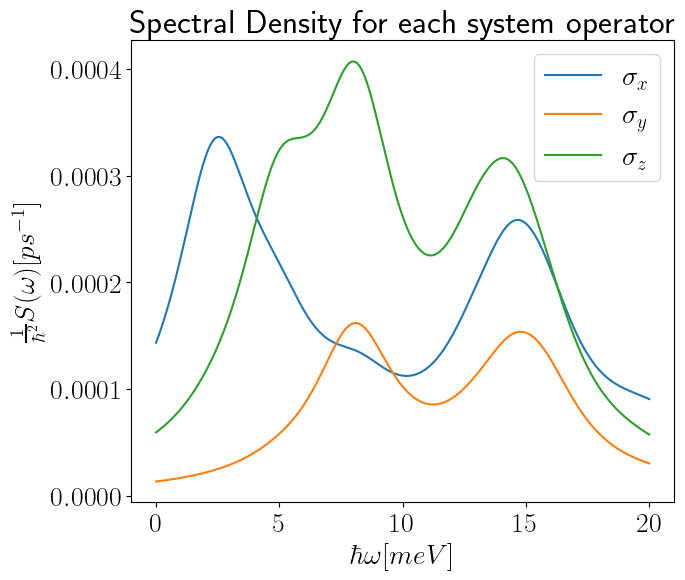

In [19]:
x = np.linspace(0, 20, 500)
yx = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=5, sigma=2)/hbar**2 for w in x]
yy = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=5, sigma=2)/hbar**2 for w in x]
yz = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]

plt.figure(figsize=(7,6))
plt.plot(x,yx)
plt.plot(x,yy)
plt.plot(x,yz)
plt.title(r"Spectral Density for each system operator ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

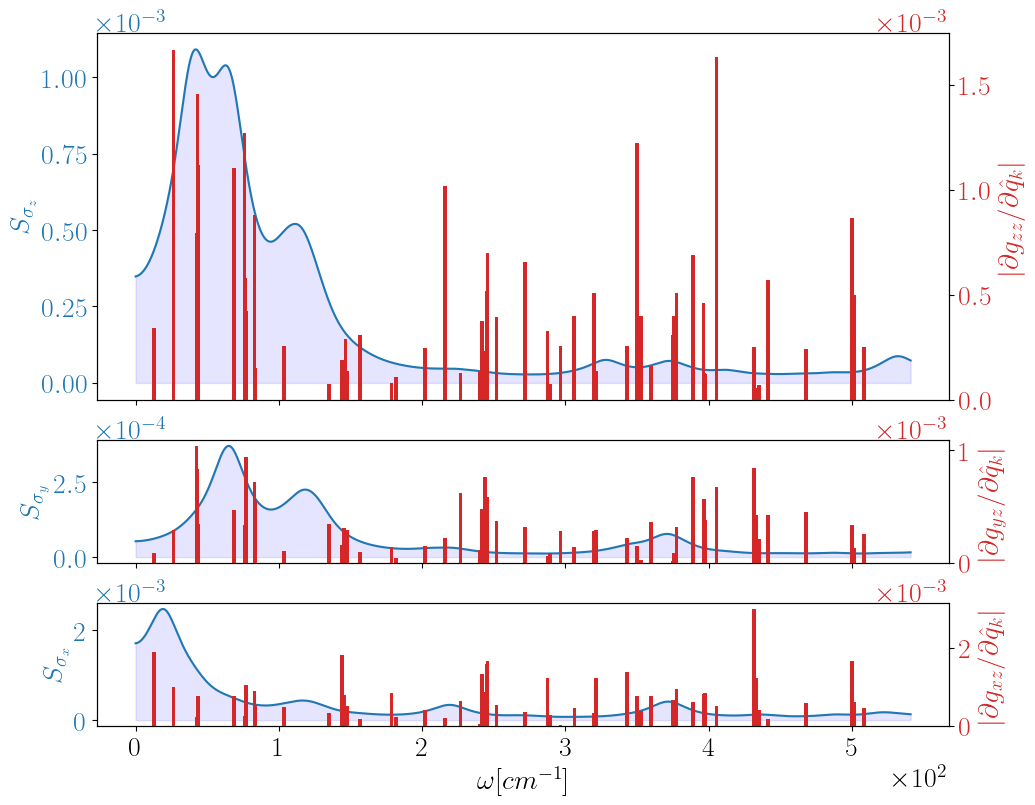

In [20]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [3, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

highfreq = 59

xspec = np.linspace(0, freq[highfreq], 5000)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S_{\sigma_z}$", color=color)
#axs[0].set_ylim([0, 5])
axs[0].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor=color)

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,2,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$S_{\sigma_y} $", color=color)
#axs[1].set_ylim([0, 5])
axs[1].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor=color)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,1,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$S_{\sigma_x}$", color=color)
#axs[2].set_ylim([0, 5])
axs[2].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor=color)

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,0,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [21]:
alpha

0.057884270182028845

## At this point it is important to note that the useful values of w at which we need S are w=0 and w=energy split

In [22]:
w_split = energies[1]- energies[0]
print(r"hbar*w_split= ", w_split, " meV, ","w_split/hbar= ", w_split/hbar, " freq")

hbar*w_split=  23.040171765750117  meV,  w_split/hbar=  35.004183273709835  freq


# Redfield with full set of modes for T1 and T2

## T1 Dynamics

10.0%. Run time:   0.11s. Est. time left: 00:00:00:01
20.0%. Run time:   0.23s. Est. time left: 00:00:00:00
30.0%. Run time:   0.35s. Est. time left: 00:00:00:00
40.0%. Run time:   0.47s. Est. time left: 00:00:00:00
50.0%. Run time:   0.59s. Est. time left: 00:00:00:00
60.0%. Run time:   0.71s. Est. time left: 00:00:00:00
70.0%. Run time:   0.83s. Est. time left: 00:00:00:00
80.0%. Run time:   0.95s. Est. time left: 00:00:00:00
90.0%. Run time:   1.07s. Est. time left: 00:00:00:00
Total run time:   1.19s


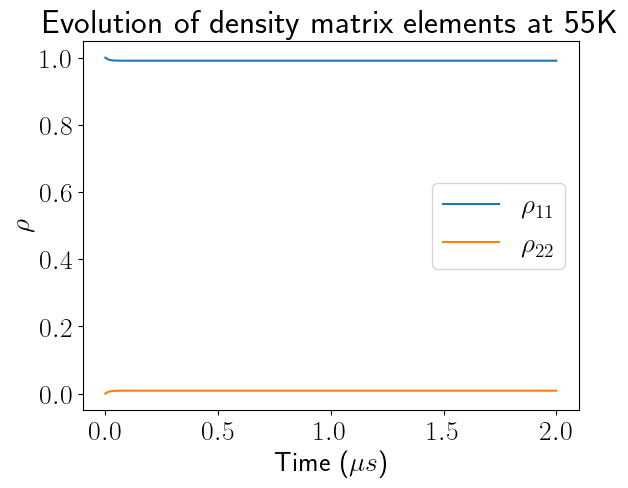

In [23]:
# Single Run
Temp = 55

tlist = np.linspace(1, 2e6, 2000) # in ps

specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=Temp, sigma=2, shape='G')/hbar**2
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=Temp, sigma=2, shape='G')/hbar**2
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(-H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, np.abs(rho22_vals))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.show()

In [24]:
kB = 8.617333262e-2 # meV/K, Boltzmann constant
w_th = kB*Temp/hbar # temperature defined as frequency
nth = n_thermal(energies[1]/hbar,w_th)
thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
thermal_rho_11

0.9191339056301834

In [25]:
# curve fitting to extract T1.
def t1_func_thermal(x,t1):
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*Temp/hbar # temperature defined as frequency
    nth = n_thermal(energies[1]/hbar,w_th)
    thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
    return (1-thermal_rho_11)*np.exp(-x/t1)+thermal_rho_11

def t1_func(x,t1, xinf):
    return (1-xinf)*np.exp(-x/t1)+xinf
    
def t1_func_classical(x,t1):
    return (1/2)*np.exp(-x/t1) + (1/2)

In [26]:
fthermal, df = curve_fit(t1_func_thermal, tlist/1e3, np.abs(rho11_vals))
fclassical, df = curve_fit(t1_func_classical, tlist/1e3, np.abs(rho11_vals))
f, df = curve_fit(t1_func, tlist/1e3, np.abs(rho11_vals))
f

array([14.70529155,  0.99104578])

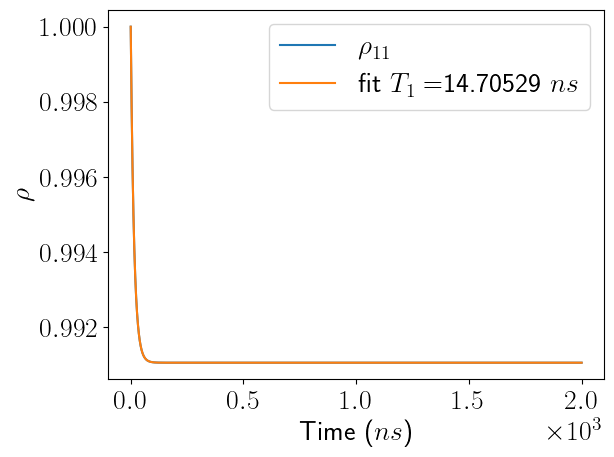

In [27]:
fit_thermal = np.array([t1_func_classical(k, fthermal)  for k in tlist/1e3])
fit_classical = np.array([t1_func_classical(k, fclassical)  for k in tlist/1e3])
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist/1e3])
plt.figure()
plt.plot(tlist/1e3, np.abs(rho11_vals))
plt.plot(tlist/1e3, fit_f)
#plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($n s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(np.round(f,5)[0])+r"$\ n s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,5)[0])+r"$\ n s$"])
plt.show()

## T2 Dynamics

In [28]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [29]:
tlist_t2 = np.linspace(1, 2e4, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()

e_ops = []
specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=Temp, sigma=2)/hbar**2
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=Temp, sigma=2)/hbar**2
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=Temp, sigma=2)/hbar**2
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho12 = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # 12 element of rho vs time 

10.0%. Run time:   1.80s. Est. time left: 00:00:00:16
20.0%. Run time:   3.61s. Est. time left: 00:00:00:14
30.0%. Run time:   5.42s. Est. time left: 00:00:00:12
40.0%. Run time:   7.22s. Est. time left: 00:00:00:10
50.0%. Run time:   9.02s. Est. time left: 00:00:00:09
60.0%. Run time:  10.71s. Est. time left: 00:00:00:07
70.0%. Run time:  12.19s. Est. time left: 00:00:00:05
80.0%. Run time:  14.06s. Est. time left: 00:00:00:03
90.0%. Run time:  16.04s. Est. time left: 00:00:00:01
Total run time:  17.56s


In [30]:
def t2_func(x,t2):
    return np.exp(-x/t2)

In [31]:
t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12))
t2

array([0.00164085])

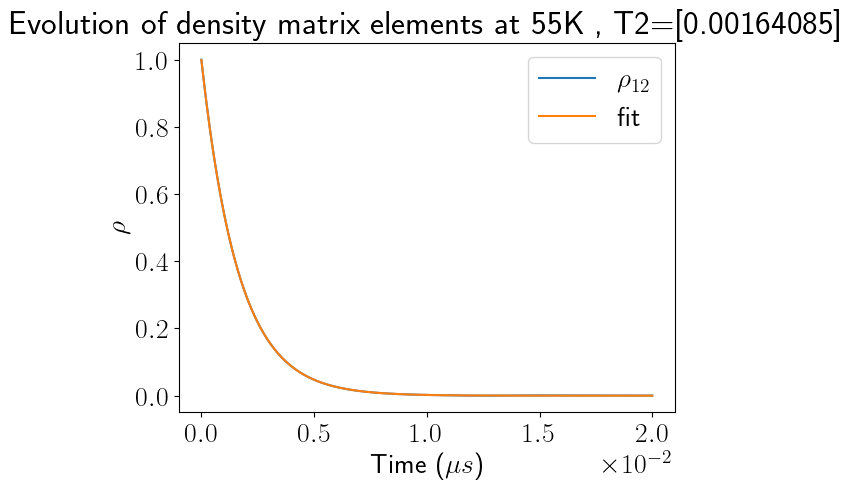

In [32]:
fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

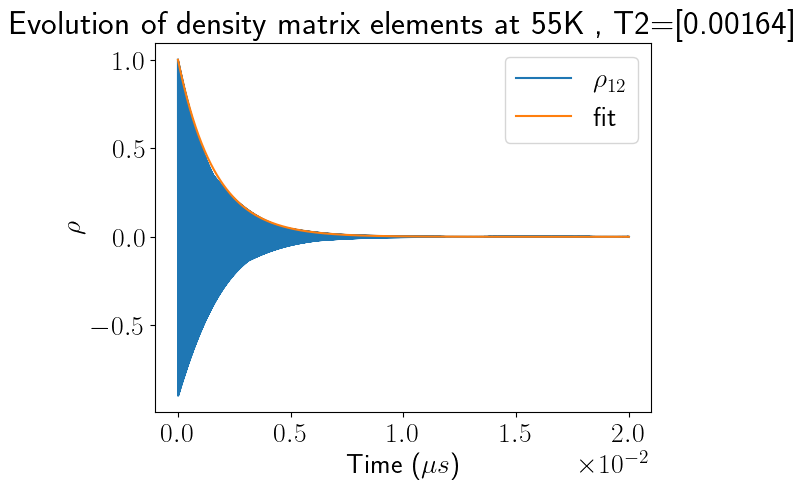

In [33]:
fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.real(rho12))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(np.round(t2,5)))
plt.legend([r"$\rho_{12}$", r"fit "])
plt.show()

# SVD Mode projection

In [34]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [0.0062195  0.00386287 0.00218791]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [170.05228774 352.20783648 533.98046135]
With SVD mode projection, system modes meV =  [21.08379664 43.6682064  66.20513965]


In [35]:
# Entropy of the projected system modes.import numpy as np
from scipy.stats import entropy

pk0 = np.squeeze(Ks[0].full().real)**2
pk1 = np.squeeze(Ks[1].full().real)**2
pk2 = np.squeeze(Ks[2].full().real)**2

print(entropy(pk0, base=np.e), entropy(pk1, base=np.e), entropy(pk2, base=np.e))

1.963627584655974 3.224787498040542 3.42358694061124


In [36]:
veclist = np.hstack((Ks,Kb))
gnewX = np.real(np.squeeze( (Qobj(gcoupS[:,0]).transform(veclist)).full()[:ns] ))
gnewY = np.real(np.squeeze( (Qobj(gcoupS[:,1]).transform(veclist)).full()[:ns] ))
gnewZ = np.real(np.squeeze( (Qobj(gcoupS[:,2]).transform(veclist)).full()[:ns] ))
# note: I have taken real parts only after inspecting that the imaginary parts are zeros.
print(gnewX, gnewY, gnewZ)

[ 0.01764258  0.03213509 -0.01637719] [ 0.00649644 -0.01869142  0.00790964] [0.01223577 0.01651691 0.0319639 ]


In [37]:
L = P*Omega*Q + Q*Omega*P
newL = L.transform(veclist).tidyup(atol=1e-6)
newL

Quantum object: dims = [[190], [190]], shape = (190, 190), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.         ...   549.88490675
  -2034.69847177  1522.66222051]
 [    0.             0.             0.         ...  1490.49011054
  -2239.24944268  2708.59015384]
 [    0.             0.             0.         ... -2236.99445614
   -622.16677135  -311.7531786 ]
 ...
 [  549.88490675  1490.49011054 -2236.99445614 ...     0.
      0.             0.        ]
 [-2034.69847177 -2239.24944268  -622.16677135 ...     0.
      0.             0.        ]
 [ 1522.66222051  2708.59015384  -311.7531786  ...     0.
      0.             0.        ]]

In [38]:
gamma_prime = np.real(newL.full()[:ns,ns:]) # the first index for gamma prime is for system phonon and second for bath phonon
Qobj(gamma_prime)

Quantum object: dims = [[3], [187]], shape = (3, 187), type = oper, isherm = False
Qobj data =
[[ 1.25245512e+00  2.01676996e-01 -7.55676323e+00  1.26396849e+01
   1.06638983e+01 -4.07620893e+00 -5.30714920e-01 -2.28432553e+00
  -1.54530484e+01 -1.41383183e+01 -5.28414760e+01 -5.81306147e+00
  -6.43523092e+00  3.43067280e+00 -2.90683993e+00 -2.68904638e+01
   1.03843422e+01  4.22661752e+01 -2.57163980e+01 -6.45645892e+00
   6.89781642e+01 -1.81670128e+01  4.72324934e+01 -7.67600442e+01
   8.76288022e+00  1.98548325e+01 -9.37287173e+01 -1.17242136e+02
  -2.06376037e+00  5.46760703e+01 -3.91504433e+01 -1.47972821e+01
   1.17556153e+02 -4.49086182e+01  2.02239802e+02  8.90743468e+01
  -1.33032512e+02 -1.93765289e+01 -2.74575291e+00 -8.22198882e+01
   6.06604327e+01 -2.07704634e+01 -1.23854026e+02 -3.72611166e+00
   4.28600784e+01 -2.94093707e+01 -6.34802073e+01  2.04166519e+02
   3.03149955e+01 -3.76336942e+01 -1.44705364e+02  5.01948130e+01
  -2.33943854e+02  6.91401598e+00  1.62251591e+

In [39]:
omega_s/cm2mev

array([170.05228774, 352.20783648, 533.98046135])

## Analysis of projected modes

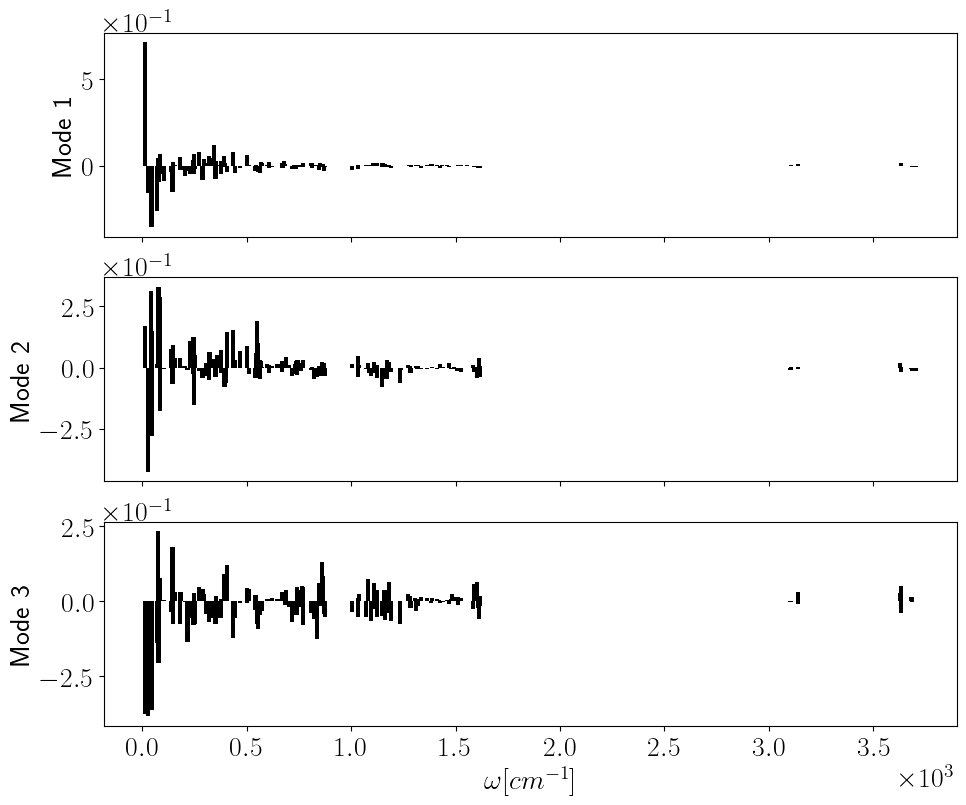

In [40]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [1, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"Mode 1", color='k')
#axs[0].set_ylim([0, 5])
axs[0].bar(freq/cm2mev,np.squeeze(Ks[0].full().real), width=20, color='k')
#axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor='k')

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############


color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"Mode 2", color='k')
#axs[1].set_ylim([0, 5])
axs[1].bar(freq/cm2mev,np.squeeze(Ks[1].full().real), width=20, color='k')
#axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor='k')

#ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"Mode 3", color='k')
#axs[2].set_ylim([0, 5])
axs[2].bar(freq/cm2mev,np.squeeze(Ks[2].full().real), width=20, color='k')
#axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor='k')

#ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [41]:
np.squeeze(np.array([Ks[0].full(), Ks[1].full(),Ks[2].full()])).transpose().shape

(190, 3)

### Spectral Densities of projected and bath modes

In [42]:
Temp = 55

In [43]:
def spectral_density_coupled_modes_classical(w, gcoup, gamma_coup, omega_s, omega_b, T=10, sigma=2):
    '''
    Generates spectral density of system modes affecting the spin system. The system modes are coupled to the bath
    modes. The units of gcoup, gamma_coup, omega_s and omega_b should all be energy.
    The units of spectral density are Eng^2 s. Therefore, division by hbar^2 must be done afterwards.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    #gamma = 2 # dampng meV
    S = 0

    for r in range(len(omega_s)):
        for rp in range(len(omega_s)):
            wr = omega_s[r]/hbar # freq of system phonon r
            wrp = omega_s[rp]/hbar # freq of system phonon rp
            cr = gcoup[r]/(np.sqrt(hbar/wr)) # energy / length
            crp = gcoup[rp]/(np.sqrt(hbar/wrp)) # energy / length

            for j in range(len(omega_b)):
                wj = omega_b[j]/hbar # freq of bath phonons
                gamma = sigma #0.2*wj # dampng rate = 20 % of mode frequency
                grj = gamma_coup[r,j]/( np.sqrt(hbar/wr)*np.sqrt(hbar/wj) ) # energy/length^2
                grpj = gamma_coup[rp, j]/( np.sqrt(hbar/wrp)*np.sqrt(hbar/wj) )# energy/length^2
                factor1 = (wj**2 - w**2)**2 + (gamma**2)*(w**2)
                factor2 = (wr**2-w**2)*(wrp**2-w**2)
                S += (cr*crp)*(grj*grpj)*(2*gamma*kB*T)/(factor1*factor2)
                #S += (2*gamma*kB*T)/(factor1*factor2)
    return S

In [44]:
Temp

55

In [45]:
gnewX, gnewY, gnewZ

(array([ 0.01764258,  0.03213509, -0.01637719]),
 array([ 0.00649644, -0.01869142,  0.00790964]),
 array([0.01223577, 0.01651691, 0.0319639 ]))

In [46]:
x = np.linspace(0,freq[-1], 1000)
#yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
#yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
yZ = [spectral_density_coupled_modes_classical(x/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp) for x in x]


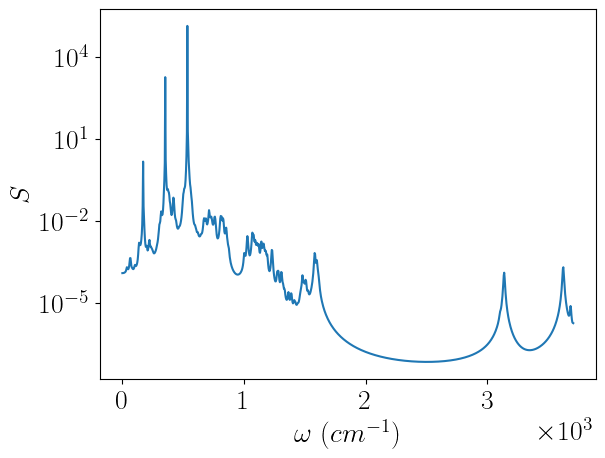

In [47]:
plt.figure()
#plt.plot(x/cm2mev,yX)
#plt.plot(x/cm2mev,yY)
plt.plot(x/cm2mev,yZ)
#plt.plot(omega_s/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_s[:165]], 'x')
#plt.plot(omega_b[:165]/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_b[:165]], '.')
plt.yscale('log')
plt.ylabel(r"$S$")
plt.xlabel(r"$\omega\ (cm^{-1})$")
#plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

In [48]:
gamma_prime[2,:].shape

(187,)

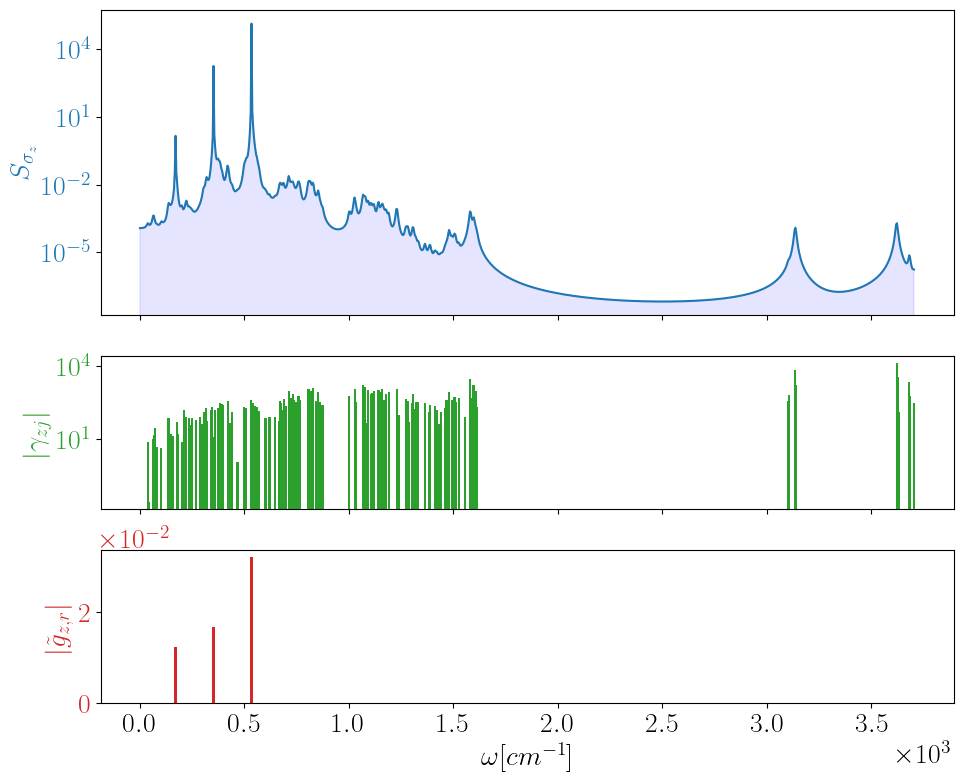

In [49]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)


color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S_{\sigma_z}$", color=color)
#axs[0].set_ylim([0, 5])
axs[0].plot(x/cm2mev,np.array(yZ),color=color)
axs[0].fill_between(x/cm2mev, np.array(yZ), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].set_yscale('log')

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\gamma_{z,j}|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yscale('log')

#ax2.bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color='tab:black')
#############

color = 'tab:green'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$|\gamma_{zj}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[1].bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
axs[1].tick_params(axis='y', labelcolor=color)
axs[1].set_yscale('log')

##############################


color = 'tab:red'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$|\tilde{g}_{z,r}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[2].bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color=color)
axs[2].tick_params(axis='y', labelcolor=color)
#axs[2].set_yscale('log')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [50]:
spectral_density_classical(w_split/hbar, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2

8.630429117546362e-07

In [51]:
spectral_density_coupled_modes_classical(w_split/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=5)/hbar**2

0.00042792216225249173

# Spin dyanmics after Mode Projection

### Method 4

Using Refield dyanmics wiht coupled oscillator spectral density

In [52]:
1/np.pi

0.3183098861837907

In [53]:
np.sqrt(np.pi)

1.7724538509055159

In [54]:
np.sqrt(2/np.pi)

0.7978845608028654

In [55]:
np.sqrt(np.pi/2)

1.2533141373155001

#### T1 dynamics

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.36s. Est. time left: 00:00:00:00
40.0%. Run time:   0.48s. Est. time left: 00:00:00:00
50.0%. Run time:   0.61s. Est. time left: 00:00:00:00
60.0%. Run time:   0.73s. Est. time left: 00:00:00:00
70.0%. Run time:   0.85s. Est. time left: 00:00:00:00
80.0%. Run time:   0.97s. Est. time left: 00:00:00:00
90.0%. Run time:   1.10s. Est. time left: 00:00:00:00
Total run time:   1.22s


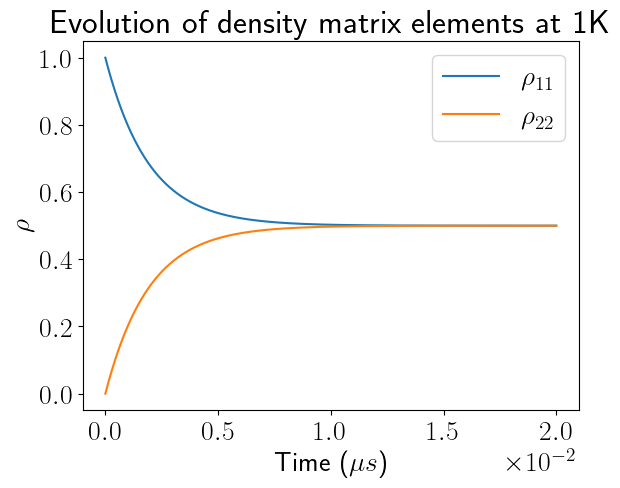

In [56]:
# Single Run
Temp = 1

tlist = np.linspace(1, 2e4, 2000) # in ps

specDensityX = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2
specDensityY = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2
specDensityZ = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2

e_ops = []

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(-H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, np.abs(rho22_vals))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.show()

/home/nyoun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


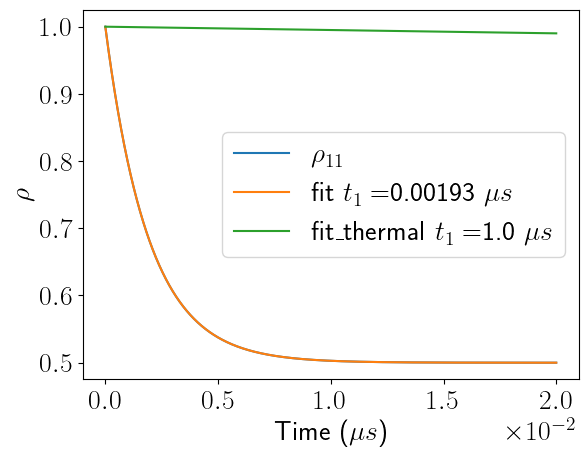

In [57]:
fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_vals))
fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_vals))
f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_vals))

fit_thermal = np.array([t1_func_classical(k, fthermal)  for k in tlist/1e6])
fit_classical = np.array([t1_func_classical(k, fclassical)  for k in tlist/1e6])
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist/1e6])
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, fit_f)
plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,5)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,5)[0])+r"$\ \mu s$"])
plt.show()

#### T2 with mode projection

In [58]:
tlist_t2 = np.linspace(1, 1e6, 10000) # in ps
psi0 = (basis(2,0)+basis(2,1)).unit()
rho0 = psi0*psi0.dag() #basis( basis(2,0)*basis(2,1).dag()
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [59]:
e_ops = []
specDensityX = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2
specDensityY = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2
specDensityZ = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=Temp, sigma=2)/hbar**2

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]

options = Options()
options.nsteps = 10000
results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops, progress_bar=True, options=options)

rho12 = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # 12 element of rho vs time 

/home/nyoun/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [60]:
t2, t2d = curve_fit(t2_func, tlist_t2/1e6, 2*np.abs(rho12))
t2

array([0.1499318])

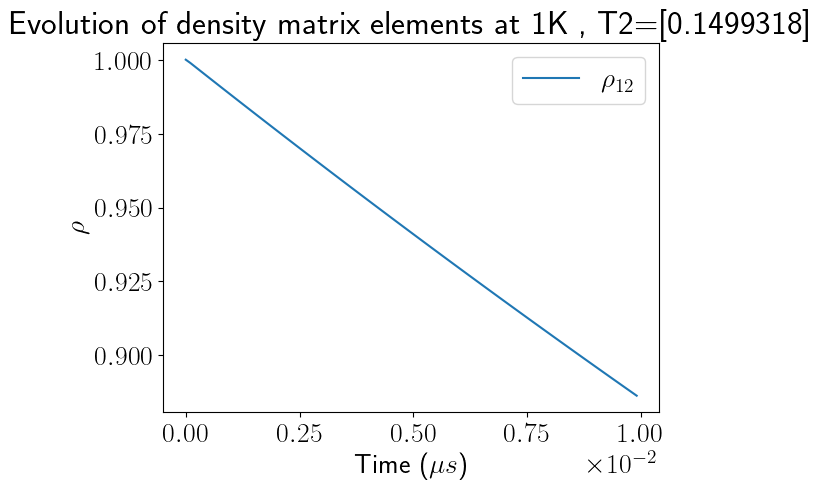

In [61]:
#fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])
lim = 100
plt.figure()
plt.plot(tlist_t2[:lim]/1e6, np.abs(rho12[:lim]))
#plt.plot(tlist_t2[:3]/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

### Method 5 
Using Redfield dyanmics to extract t1 and t2 of the projected modes then putting them with spin in lindblad formulism


In [62]:
omega_s

array([21.08379664, 43.6682064 , 66.20513965])

In [63]:
destroy(2).dag()*destroy(2)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.24s. Est. time left: 00:00:00:00
50.0%. Run time:   0.30s. Est. time left: 00:00:00:00
60.0%. Run time:   0.36s. Est. time left: 00:00:00:00
70.0%. Run time:   0.42s. Est. time left: 00:00:00:00
80.0%. Run time:   0.49s. Est. time left: 00:00:00:00
90.0%. Run time:   0.55s. Est. time left: 00:00:00:00
Total run time:   0.61s


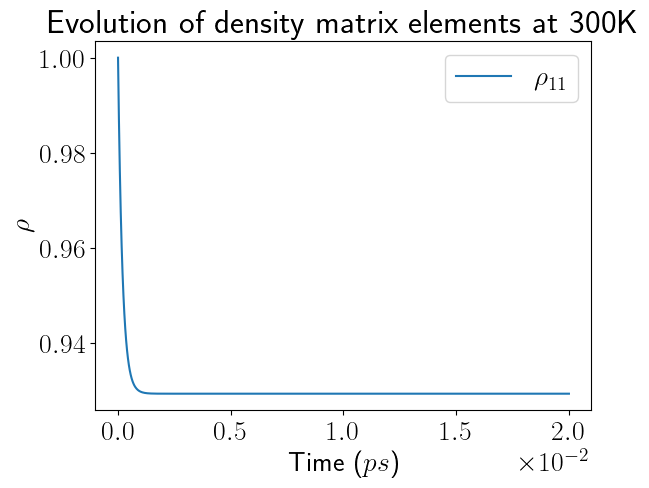

In [64]:
mode = 2
Hp = omega_s[mode]*destroy(2).dag()*destroy(2)
x = np.sqrt(hbar/(2*omega_s[mode]))*(destroy(2)+destroy(2).dag()) # displacement operator for the mode0

# Single Run
Temp = 300

tlist = np.linspace(0, 2e-2, 1000) # in ps

specDensityBathModes = lambda w : spectral_density_quantum(w, freqs=omega_b, coup=gamma_prime[mode,:], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[x,specDensityBathModes]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(Hp/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])
rho12_vals = np.array([results1.states[k].full()[0,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist, np.abs(rho11_vals))
#plt.plot(tlist, np.abs(rho22_vals))
##plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
#plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
#plt.legend([r"$\rho_{12}$"])
plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(fthermal,5)[0])+r"$\ p s$"])

plt.show()


the T1 time in ps 0.00019536822126419232


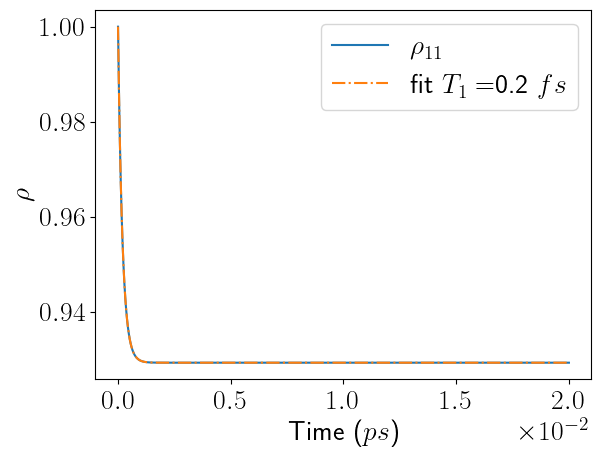

In [65]:
f, df = curve_fit(t1_func, tlist, np.abs(rho11_vals))
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist])
plt.figure()
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, fit_f, '-.')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(1000*fthermal,5)[0])+r"$\ fs$"])
print('the T1 time in ps', f[0])

In [66]:
# t1 times for the phonons
t1p = [0.012837945681530277, 0.0005711617135254505, 0.00019536814504390486]

### Computing T2 time

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.19s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.31s. Est. time left: 00:00:00:00
60.0%. Run time:   0.37s. Est. time left: 00:00:00:00
70.0%. Run time:   0.43s. Est. time left: 00:00:00:00
80.0%. Run time:   0.50s. Est. time left: 00:00:00:00
90.0%. Run time:   0.56s. Est. time left: 00:00:00:00
Total run time:   0.62s


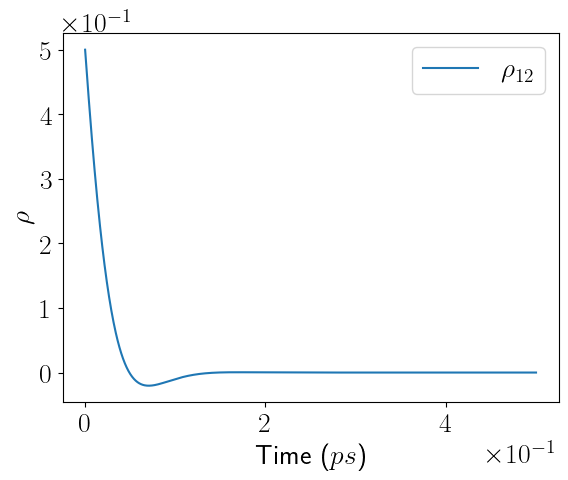

In [67]:
mode = 0
Hp = omega_s[mode]*destroy(2).dag()*destroy(2)
x = np.sqrt(hbar/(2*omega_s[mode]))*(destroy(2)+destroy(2).dag()) # displacement operator for the mode0

# Single Run
Temp = 300

tlist = np.linspace(0, 5e-1, 1000) # in ps

specDensityBathModes = lambda w : spectral_density_quantum(w, freqs=omega_b, coup=gamma_prime[mode,:], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[x,specDensityBathModes]]


rho0 = ket2dm((basis(2,0)+basis(2,1)).unit())
results1 = brmesolve(Hp/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])
rho12_vals = np.array([results1.states[k].full()[0,1] for k in range(len(tlist))])

plt.figure()
#plt.plot(tlist, np.abs(rho11_vals))
#plt.plot(tlist, np.abs(rho22_vals))
plt.plot(tlist, np.real(rho12_vals))
##plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
#plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.legend([r"$\rho_{12}$"])
#plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(fthermal,5)[0])+r"$\ p s$"])

plt.show()


In [68]:
ket2dm(basis(2,0)+basis(2,1)).unit()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


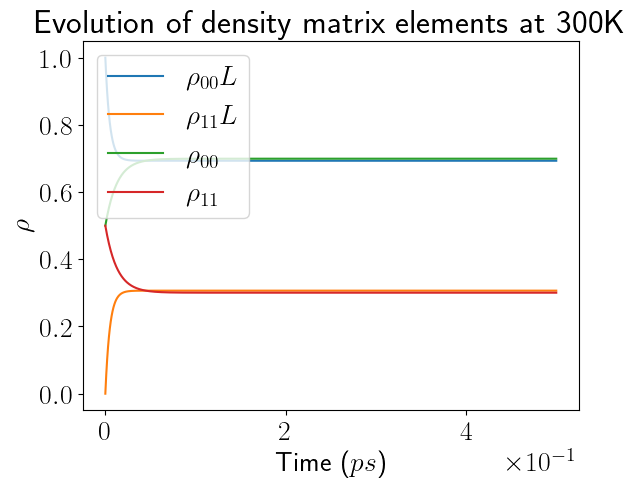

In [69]:
e_ops = []
#cops = [c0*x]
n_th = n_thermal(omega_s[mode], kB*Temp)
cops = [np.sqrt((1/t1p[mode]) * (1+n_th)) * destroy(2), np.sqrt((1/t1p[mode]) * (n_th)) * destroy(2).dag()]

rho0 = basis(2,0)*basis(2,0).dag()
results2 = mesolve(Hp/(hbar), rho0, tlist, c_ops=cops, e_ops=e_ops, progress_bar=True)

rho11_vals_L = np.array([results2.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals_L = np.array([results2.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist, np.abs(rho11_vals_L))
plt.plot(tlist, np.abs(rho22_vals_L))
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, np.abs(rho22_vals))
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{00}L$", r"$\rho_{11}L$", r"$\rho_{00}$", r"$\rho_{11}$"])
plt.show()

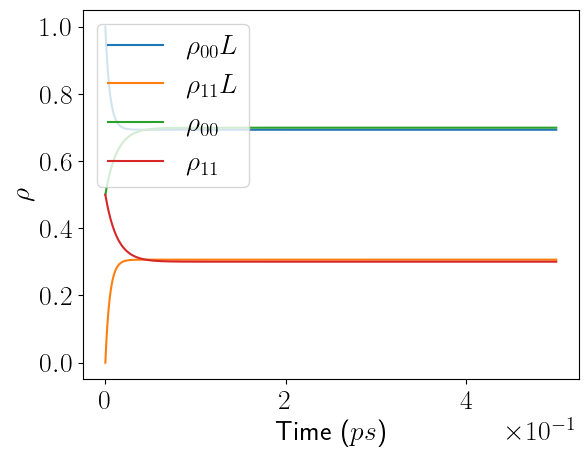

In [70]:
plt.figure()
plt.plot(tlist, np.abs(rho11_vals_L))
plt.plot(tlist, np.abs(rho22_vals_L))
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, np.abs(rho22_vals))
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{00}L$", r"$\rho_{11}L$", r"$\rho_{00}$", r"$\rho_{11}$"])
plt.show()

### Lindblad operators

In [196]:
x0 = np.sqrt(hbar/(2*omega_s[0]))*(destroy(2)+destroy(2).dag()) # displacement operator for the mode0
x1 = np.sqrt(hbar/(2*omega_s[1]))*(destroy(2)+destroy(2).dag())
x2 = np.sqrt(hbar/(2*omega_s[2]))*(destroy(2)+destroy(2).dag())
X0 = tensor(x0, qeye(2), qeye(2), qeye(2))
X1 = tensor(qeye(2), x1, qeye(2), qeye(2))
X2 = tensor(qeye(2), qeye(2), x2, qeye(2))
A0 = tensor(destroy(2), qeye(2), qeye(2), qeye(2))
A1 = tensor(qeye(2), destroy(2), qeye(2), qeye(2))
A2 = tensor(qeye(2), qeye(2), destroy(2), qeye(2))

In [197]:
Hp = omega_s[0]*A0.dag()*A0 + omega_s[1]*A1.dag()*A1 + omega_s[2]*A2.dag()*A2
#Hp

In [198]:
#omega_s[0]*A0

In [199]:
isequal(tensor(omega_s[0]*destroy(2), qeye(2), qeye(2), qeye(2)), omega_s[0]*A0)

True

In [200]:
Hint = (gnewX[0]*X0 + gnewX[1]*X1 + gnewX[2]*X2)*tensor(qeye(2), qeye(2), qeye(2),sigma_vec[0])
Hint += (gnewY[0]*X0 + gnewY[1]*X1 + gnewY[2]*X2)*tensor(qeye(2), qeye(2), qeye(2),sigma_vec[1])
Hint += (gnewZ[0]*X0 + gnewZ[1]*X1 + gnewZ[2]*X2)*tensor(qeye(2), qeye(2), qeye(2),sigma_vec[2])
#Hint

In [201]:
Hspin = tensor(qeye(2), qeye(2), qeye(2), H)
Htotal = Hp#+Hint+Hspin
#Htotal

In [202]:
p0 = basis(2,1)*basis(2,1).dag()
p1 = basis(2,0)*basis(2,0).dag()
p2 = basis(2,0)*basis(2,0).dag()
s = basis(2, 1)*basis(2,1).dag()
########### defining the tensorproduct states ###################
P0 = tensor(p0, qeye(2), qeye(2), qeye(2))
P1 = tensor(qeye(2), p1, qeye(2), qeye(2))
P2 = tensor(qeye(2), qeye(2), p2, qeye(2))
S = tensor(qeye(2), qeye(2), qeye(2), s)
#################################################################
rho = tensor(p0, p1, p2, s)
#rho

In [203]:
# performing the lindblad time evolution 
proj0 = tensor(qeye(2), qeye(2), qeye(2), basis(2,0)*basis(2,0).dag())
proj1 = tensor(qeye(2), qeye(2), qeye(2), basis(2,1)*basis(2,1).dag())

p0_00 = tensor(basis(2,0)*basis(2,0).dag(), qeye(2), qeye(2), qeye(2))
p0_11 = tensor(basis(2,1)*basis(2,1).dag(), qeye(2), qeye(2), qeye(2))

p1_00 = tensor(qeye(2), basis(2,0)*basis(2,0).dag(), qeye(2), qeye(2))
p1_11 = tensor(qeye(2), basis(2,1)*basis(2,1).dag(), qeye(2), qeye(2))

p2_00 = tensor(qeye(2), qeye(2), basis(2,0)*basis(2,0).dag(), qeye(2))
p2_11 = tensor(qeye(2), qeye(2), basis(2,1)*basis(2,1).dag(), qeye(2))

#cops = [c0*X0, c1*X1, c2*X2]

n_th = n_thermal(omega_s[0], kB*Temp)
cops = [np.sqrt((1/t1p[0]) * (0 + n_th)) * A0, np.sqrt((1/t1p[0]) * (1 + n_th)) * A0.dag()]
n_th = n_thermal(omega_s[1], kB*Temp)
cops += [np.sqrt((1/t1p[1]) * (1 + n_th)) * A1, np.sqrt((1/t1p[1]) * n_th) * A1.dag()]
n_th = n_thermal(omega_s[2], kB*Temp)
cops += [np.sqrt((1/t1p[2]) * (1 + n_th)) * A2, np.sqrt((1/t1p[2]) * n_th) * A2.dag()]

eops = [p0_11, p0_00, A0.dag()*A0, proj0, proj1]

In [204]:
#tlistp = np.linspace(0, 1e5, int(6e4)) # time in ps
tlistp = np.linspace(0, 1, int(1e3)) # time in ps
results = mesolve(Htotal/hbar, rho, tlistp, c_ops=cops, e_ops=eops, progress_bar=True)

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.06s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.09s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
70.0%. Run time:   0.13s. Est. time left: 00:00:00:00
80.0%. Run time:   0.15s. Est. time left: 00:00:00:00
90.0%. Run time:   0.17s. Est. time left: 00:00:00:00
Total run time:   0.19s


Text(0, 0.5, 'expectation value')

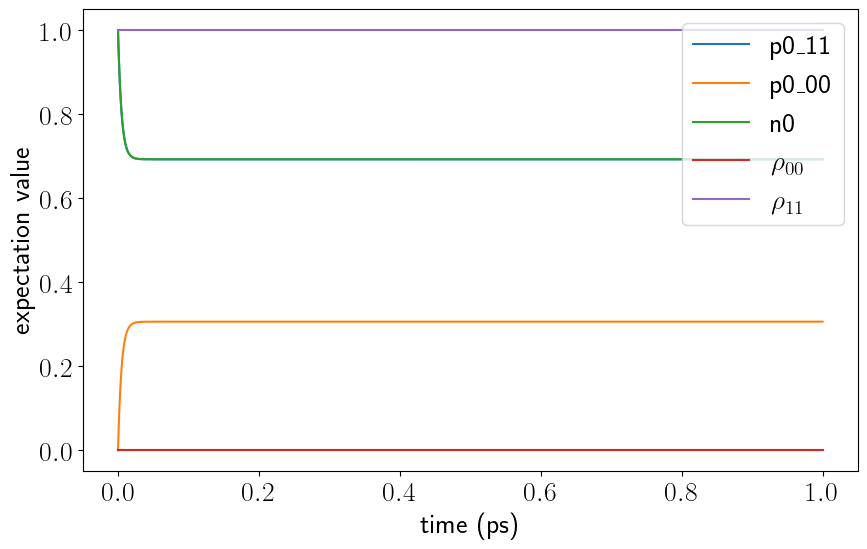

In [207]:
labels = ["p0_11", "p0_00", "n0", r"$\rho_{00}$", r"$\rho_{11}$"]
plt.figure(figsize=(10,6))
for i in range(5):
    plt.plot(tlistp, results.expect[i].real)
plt.legend(labels, loc = 'upper right')
plt.xlabel('time (ps)')
plt.ylabel('expectation value')
    

In [121]:
np.round(omega_s, 2)

array([21.08, 43.67, 66.21])